Dev:        In Woo Park 
Date:       5/11/2022
Assignment: Final Project 

# Titanic - Machine Learning From Disaster

Spring 2022 ICS 435/635 started with a Kaggle Competition. Therefore, it is only appropriate to end with a Kaggle Competition as well. My Final Project for this class is an attempt at the "Titanic - Machine Learning Disaster" Competition from Kaggle. They have provided a training set and a test set for people to use and an example submission that only needs two attributes, Passenger ID and if they survived (i.e., 0 - No, 1 - Yes). 

#Workflow 

1.   Preliminary Imports
2.   Classify the data
3.   Preprocess the data
5.   Run it!


# Preliminary Imports 
We begin by adding the necessary libraries. 

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import io
import math

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

import sklearn

Once the libraries are imported, we upload the training and test set for panda dataframe. 

In [2]:
# I used this method to upload files using google colab 
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [3]:
# Supress Exception Warning 
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
class ChainedAssignment:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw


#Classify The Data

Once the datasets are uploaded, we make it available through Pandas DataFrames.

The Titanic Dataset can be interpreted as: 

1. survival - Survival (0 = No; 1 = Yes)
2. class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
3. name - Name
4. sex - Sex
5. age - Age
6. sibsp - Number of Siblings/Spouses Aboard
7. parch - Number of Parents/Children Aboard
8. ticket - Ticket Number
9. fare - Passenger Fare
10. cabin - Cabin
11. embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)



In [4]:
#Decode the files for Pandas Library
train_df = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test_df = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
combine = [train_df, test_df]

#Print the features of the dataset
print(train_df.columns.values)
print(test_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [5]:
#Preview the training/test dataset

print(train_df.tail())
print("________________________________________________")
print(test_df.tail())

#Preview training/test dataset datatypes
print(train_df.info())
print("_______________________________________________")
print(test_df.info())

     PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q  
________________________________________________
     PassengerId  Pclass                          Name     Sex

1. We know that the difference between the training dataset and the test dataset are the features provided. Namely, the test dataset is missing the "survived" attribute because we have to make a prediction if they survived. 

2. Several attributes have missing values. These attributes are Age, Cabin, and Embarked for the training dataset. However, Embarked values are missing for 2 passengers only, namely, PassengerID: 62 and PassengerID: 830. As of right now, it seems like that the missing data is insignificant as the test dataset does not have missing Embarked values, only Age and Cabin values are missing. 

3. According to the challenge overview (https://www.kaggle.com/competitions/titanic/overview), there were 1502 fatalities out of 2224 passengers and crew. This suggests our training data accounts for approximately (891/2224) = 0.40062.. or 40% of the actual number of passengers. In addition, (2224-1502)/2224 = 0.3246.. or 32% actual survival rate. Compared to the dataset of 38% survival rate. 

4. For cabin data, 77% are NULL, 22% Other 

5. For Embarked data, 72% S, 19% C, 9% Other 

In [7]:
#Distribution of features
survivor_count = 0
parch_count = 0
sibling_count = 0
male_count = 0
female_count = 0

#Calculate how many people survived in the training set
#Calculate parch (Did a passenger have a parent or child on board?)
#Calculate siblings in the training set (Did a passenger have a sibling on board?)
#Calculate sex difference
for x in range(len(train_df)):
  survivor_count += train_df.Survived[x]

  if (train_df.Parch[x] > 0):
    parch_count += 1

  if (train_df.SibSp[x] > 0): 
    sibling_count += 1

  if (train_df.Sex[x] == "male"):
    male_count += 1

female_count = len(train_df) - male_count

print("Training set survivor count:",survivor_count)
x = (round(survivor_count/len(train_df), 4))*100
print("Training set survival rate:",round(x,0),"%")

print("Training set passengers with parents or children on board:", round(parch_count/len(train_df), 2)*100, "%")
print("Training set passengers with siblings on board:", round(sibling_count/len(train_df), 2)*100, "%")

print("Training set male count:", male_count)
print("Training set female count:", female_count)
print("Training set male percentage:", round(male_count/len(train_df),2)*100, "%")

Training set survivor count: 342
Training set survival rate: 38.0 %
Training set passengers with parents or children on board: 24.0 %
Training set passengers with siblings on board: 32.0 %
Training set male count: 577
Training set female count: 314
Training set male percentage: 65.0 %


In [8]:
#Print correlation values between attribute and survival on training set
print(train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")

#Print to see if where passengers got picked up is corrleated to survival
print(train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["Ticket", "Survived"]].groupby(['Ticket'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print("___________________")
print(train_df[["Fare", "Survived"]].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False))

#Print this to see who survived by age using the interactive table. 
train_df[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
___________________
      Sex  Survived
0  female  0.742038
1    male  0.188908
___________________
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
___________________
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
___________________
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
___________________
     Ticket  Survived
0    110152       1.0
180   26360       1.0
483  386525       1.0
479  382651       1.0
151  244373       1.0
..      ...       ...
385  349246       0.0
384  349245       0.0
197    2669       0.0
382  349243       0.0
340  347464       0.0

[681 rows x 2 columns]
___________________
       Cabin  Survived
73   C62 C64       1.0
97       D21      

,Age,Survived
0,0.42,1.0
9,5.00,1.0
79,63.00,1.0
68,53.00,1.0
1,0.67,1.0
...,...,...
37,28.50,0.0
49,36.50,0.0
46,34.50,0.0
26,20.50,0.0


# Clean up the data 

In [9]:
# Remove Cabin and Ticket attributes from training and test datasets
train_df = train_df.drop(['Ticket', 'Cabin'], axis = 1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis = 1)
combine = [train_df, test_df]

# Check attributes now 
print("Training Set Updated:", train_df.columns.values)
print("Test Set Updated:", test_df.columns.values)

Training Set Updated: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Fare' 'Embarked']
Test Set Updated: ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare'
 'Embarked']


In [10]:
#Change Embarked values to ordinal 
for x in combine: 
  x ["Embarked"] = x["Embarked"].replace(["S"], int(1))
  x ["Embarked"] = x["Embarked"].replace(["C"], int(2))
  x ["Embarked"] = x["Embarked"].replace(["Q"], int(3))

#There are 2 Embarked values that are NaN, just give it "S" because it is the most common
with ChainedAssignment():
  for x in range(len(train_df)):
    if (np.isnan(train_df.Embarked[x])):
      train_df.Embarked[x] = 1 

In [11]:
#Changing Sex Values and grabbing Prefix Titles from Names 
for x in combine: 
  x['Sex'] = x['Sex'].map({'female': 1, 'male': 0}).astype(int)
  x['Prefix'] = x['Prefix'] = x.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [12]:
#Print Unique Prefix's on both datasets
list = train_df.Prefix.unique()
list2 = test_df.Prefix.unique()
print(list)
print(list2)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [13]:
#Change Prefix names to 4 types, Other, Mrs, Miss, Mr, Master (Master referes to underage < 18) based on test data 
for x in combine: 
  x['Prefix'] = x['Prefix'].replace(['Don', 'Dona','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer'], 'Other' )
  x['Prefix'] = x['Prefix'].replace(['Mme'], 'Mrs')
  x['Prefix'] = x['Prefix'].replace(['Ms'], 'Miss' )
  x['Prefix'] = x['Prefix'].replace(['Mlle'], 'Miss')

train_df[['Prefix', 'Survived']].groupby(['Prefix'], as_index=False).mean()

,Prefix,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


In [14]:
#Change values to ordinal
for x in combine: 
  x ["Prefix"] = x["Prefix"].replace(["Mr"], int(1))
  x ["Prefix"] = x["Prefix"].replace(["Miss"], int(2))
  x ["Prefix"] = x["Prefix"].replace(["Mrs"], int(3))
  x ["Prefix"] = x["Prefix"].replace(["Master"], int(4))
  x ["Prefix"] = x["Prefix"].replace(["Other"], int(5))

#Drop Names and PassengerID as we switched the values to ordinal Prefix's
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

In [15]:
#Check to see how many Age values are NaN
train_df.Age.isnull().sum(axis=0)

177

In [16]:
test_df.Age.isnull().sum(axis=0)

86

In [17]:
#We know the Prefix master means they are underage (< 18 years old), but the training set has an upperbound on "master" of 12 years old. I Cntrl + F by "Master" on the csv to check. 

#Give 4 people an Age as a Side Quest
with ChainedAssignment():
  for x in range(len(train_df)):
    if (np.isnan(train_df.Age[x])) & (train_df.Prefix[x] == 4):
      train_df.Age[x] = rnd.randint(0, 18)

#Give 4 people an Age as a Side Quest
with ChainedAssignment():
  for x in range(len(test_df)):
    if (np.isnan(test_df.Age[x])) & (test_df.Prefix[x] == 4):
      test_df.Age[x] = rnd.randint(0, 18)

#How many values are NaN now
train_df.Age.isnull().sum(axis=0)

173

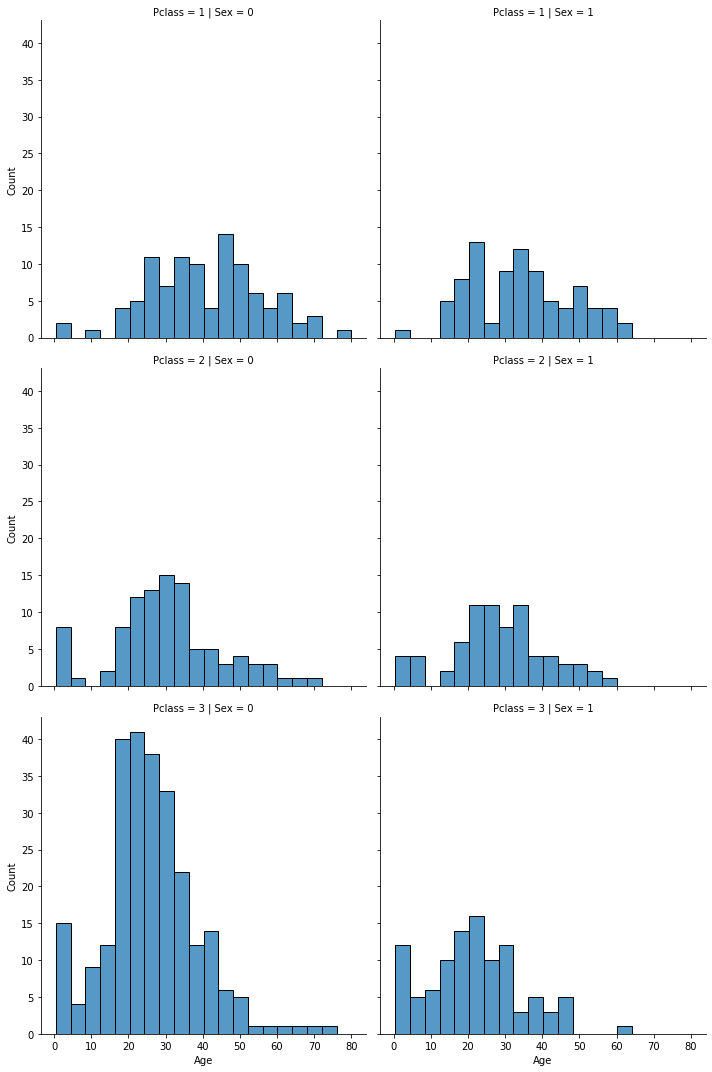

In [18]:
#Find the standard deviation amongst Male and Female passengers based on deck level so we can give it a Age value 
graph = sns.displot(train_df, x="Age", row = "Pclass", col="Sex")

In [19]:
#Finding the mean and standard deviation between Pclass and Age
#I got this from Michael Rogers 

df = train_df.copy()
print(df.where(df.Pclass == 1).groupby(['Pclass'])['Age'].describe())
print("_"*65)
print(df.where(df.Pclass == 2).groupby(['Pclass'])['Age'].describe())
print("_"*65)
print(df.where(df.Pclass == 3).groupby(['Pclass'])['Age'].describe())

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1.0     186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0
_________________________________________________________________
        count      mean        std   min   25%   50%   75%   max
Pclass                                                          
2.0     173.0  29.87763  14.001077  0.67  23.0  29.0  36.0  70.0
_________________________________________________________________
        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
3.0     359.0  24.949638  12.571571  0.42  18.0  24.0  32.0  74.0


In [20]:
#Let's Predict Age values for everyone else based on Pclass and Age mean/standard deviation 

firstc_pred = np.random.normal(38.23, 14.8)
secondc_pred = np.random.normal(29.88, 14)
thirdc_pred = np.random.normal(24.96, 12.53)

with ChainedAssignment():
  for x in range(len(train_df)):
    if (np.isnan(train_df.Age[x])) & (train_df.Pclass[x] == 1):
      train_df.Age[x] = firstc_pred
    if (np.isnan(train_df.Age[x])) & (train_df.Pclass[x] == 2):
      train_df.Age[x] = secondc_pred
    if (np.isnan(train_df.Age[x])) & (train_df.Pclass[x] == 3):
      train_df.Age[x] = thirdc_pred

#Do the same for the test set 
with ChainedAssignment():
  for x in range(len(test_df)):
    if (np.isnan(test_df.Age[x])) & (test_df.Pclass[x] == 1):
      test_df.Age[x] = firstc_pred
    if (np.isnan(test_df.Age[x])) & (test_df.Pclass[x] == 2):
      test_df.Age[x] = secondc_pred
    if (np.isnan(test_df.Age[x])) & (test_df.Pclass[x] == 3):
      test_df.Age[x] = thirdc_pred


In [21]:
#Check to see how many Age values are NaN now
train_df.Age.isnull().sum(axis=0)
test_df.Age.isnull().sum(axis=0)

0

In [22]:
#Split Age in 5 segments to see correlational data
train_df['Age_Range'] = pd.cut(train_df['Age'], 5)
train_df[['Age_Range', 'Survived']].groupby(['Age_Range'], as_index=False).mean().sort_values(by='Age_Range', ascending=True)

,Age_Range,Survived
0,"(0.34, 16.336]",0.526316
1,"(16.336, 32.252]",0.336735
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [23]:
#Change Age values to ordinal
with ChainedAssignment():
  for x in range(len(train_df)): 
    if (train_df.Age[x] <= 16):
      train_df.Age[x] = int(0) 
    if (train_df.Age[x] > 16) & (train_df.Age[x] <= 32):
      train_df.Age[x] = int(1) 
    if (train_df.Age[x] > 32) & (train_df.Age[x] <= 48):
      train_df.Age[x] = int(2)
    if (train_df.Age[x] > 48) & (train_df.Age[x] <= 64):
      train_df.Age[x] = int(3)
    if (train_df.Age[x] > 64):
      train_df.Age[x] = int(4) 

  for x in range(len(test_df)): 
    if (test_df.Age[x] <= 16):
      test_df.Age[x] = int(0) 
    if (test_df.Age[x] > 16) & (test_df.Age[x] <= 32):
      test_df.Age[x] = int(1) 
    if (test_df.Age[x] > 32) & (test_df.Age[x] <= 48):
      test_df.Age[x] = int(2)
    if (test_df.Age[x] > 48) & (test_df.Age[x] <= 64):
      test_df.Age[x] = int(3)
    if (test_df.Age[x] > 64):
      test_df.Age[x] = int(4) 
    
train_df = train_df.drop(['Age_Range'], axis = 1)
print(train_df[["Age", "Survived"]].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False))
combine = [train_df, test_df]

   Age  Survived
0  0.0  0.526316
3  3.0  0.434783
2  2.0  0.404255
1  1.0  0.336735
4  4.0  0.090909


In [24]:
#Drop people if Fares are $0 for training set
#train_df = train_df[train_df.Fare != 0]
print(len(train_df))

#Convert NaN Fares to int(0) 
with ChainedAssignment():
  for x in range(len(test_df)):
    if (np.isnan(test_df.Fare[x])):
      test_df.Fare[x] = int(0)

#Remove passengers for 0 value Fare
#test_df = test_df[test_df.Fare != 0]    

891


In [25]:
#Split Fare into segments based on distribution to see correlational data
#https://www.geeksforgeeks.org/how-to-use-pandas-cut-and-qcut/

with ChainedAssignment():
  train_df['Fare_Range'] = pd.qcut(train_df['Fare'], 4)

train_df[['Fare_Range', 'Survived']].groupby(['Fare_Range'], as_index=False).mean().sort_values(by='Fare_Range', ascending=True)

,Fare_Range,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [26]:
#Change Fare values to ordinal,# z score that bitch if it's long af 
with ChainedAssignment():
  for x in range(len(train_df)): 
    if (train_df.Fare[x] <= 7.91):
      train_df.Fare[x] = int(0) 
    if (train_df.Fare[x] > 7.91) & (train_df.Fare[x] <= 14.454):
      train_df.Fare[x] = int(1) 
    if (train_df.Fare[x] > 14.454) & (train_df.Fare[x] <= 31):
      train_df.Fare[x] = int(2)
    if (train_df.Fare[x] > 31) & (train_df.Fare[x] <= 512.329):
      train_df.Fare[x] = int(3)
    if (train_df.Fare[x] > 512.329):
      train_df.Fare[x] = int(4) 

with ChainedAssignment():
  for x in range(len(test_df)): 
    if (test_df.Fare[x] <= 7.925):
      test_df.Fare[x] = int(0) 
    if (test_df.Fare[x] > 7.925) & (test_df.Fare[x] <= 14.5):
      test_df.Fare[x] = int(1) 
    if (test_df.Fare[x] > 14.5) & (test_df.Fare[x] <= 31.275):
      test_df.Fare[x] = int(2)
    if (test_df.Fare[x] > 31.275) & (test_df.Fare[x] <= 512.329):
      test_df.Fare[x] = int(3)
    if (test_df.Fare[x] > 512.329):
      test_df.Fare[x] = int(4) 

#Drop Fare_range attribute we used previously 
train_df = train_df.drop(['Fare_Range'], axis = 1)

In [27]:
#change datatypes so it can be read 
train_df.Age = train_df.Age.astype(int)
train_df.Fare = train_df.Fare.astype(int)
train_df.Embarked = train_df.Embarked.astype(int)
                                

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int64
 7   Embarked  891 non-null    int64
 8   Prefix    891 non-null    int64
dtypes: int64(9)
memory usage: 62.8 KB


#Run it

Data is cleaned to the point we want, and now it is time to train the model.

In [30]:
#initialize features, log reg, and kfold
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Prefix']
logreg = LogisticRegression(C=5,penalty="l2",solver="newton-cg")

kf = KFold(n_splits = 5)
X = train_df[features]
y = train_df["Survived"]

#less bias because we are training on parts of the data, similar to train/test/split, we want to reduce overfit or underfit
for i, (train, valid) in enumerate(kf.split(X)):
  X_train = X.iloc[train]
  X_valid = X.iloc[valid]
  y_train = y[train]
  y_valid = y[valid]

  logreg.fit(X_train, y_train)
  y_pred_train = logreg.predict_proba(X_train)[:,1]
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_train, y_pred_train, pos_label=1)
  auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
  train_acc = round(logreg.score(X_train, y_train) * 100, 2)
  y_pred_valid = logreg.predict_proba(X_valid)[:,1]
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_valid, y_pred_valid, pos_label=1)
  auc_valid = sklearn.metrics.roc_auc_score(y_valid, y_pred_valid)
  valid_acc = round(logreg.score(X_valid, y_valid) * 100, 2)
  print('_'*30)
  print(' '*10 + f'-- Fold {i + 1} -- ')
  print(f'Accuracy: {train_acc:0.2f}% (train)\n\t  {valid_acc:0.2f}% (validation)')
  print(f'AUROC   : {auc_train:0.2f} (train)\n\t  {auc_valid:0.2f} (validation)')

______________________________
          -- Fold 1 -- 
Accuracy: 80.20% (train)
	  79.89% (validation)
AUROC   : 0.87 (train)
	  0.84 (validation)
______________________________
          -- Fold 2 -- 
Accuracy: 80.65% (train)
	  78.65% (validation)
AUROC   : 0.87 (train)
	  0.86 (validation)
______________________________
          -- Fold 3 -- 
Accuracy: 80.22% (train)
	  80.34% (validation)
AUROC   : 0.87 (train)
	  0.87 (validation)
______________________________
          -- Fold 4 -- 
Accuracy: 81.21% (train)
	  75.28% (validation)
AUROC   : 0.87 (train)
	  0.85 (validation)
______________________________
          -- Fold 5 -- 
Accuracy: 79.38% (train)
	  83.71% (validation)
AUROC   : 0.86 (train)
	  0.90 (validation)


<function matplotlib.pyplot.show>

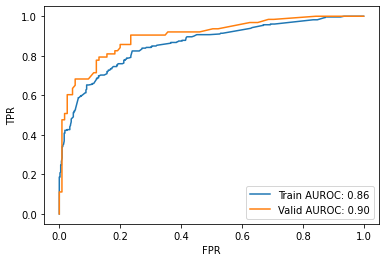

In [31]:
# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_train, y_pred_train, pos_label=1)
plt.plot(fpr, tpr, label=f'Train AUROC: {auc_train:0.2f}')
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_valid, y_pred_valid, pos_label=1)
plt.plot(fpr, tpr, label=f'Valid AUROC: {auc_valid:0.2f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show

In [32]:
y_pred_test = logreg.predict(test_df[features])
#Create a file to submit to Kaggle as a csv.
submit = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": y_pred_test})
submit.to_csv('submit_kfoldonlogres.csv', index = False)
files.download('submit_kfoldonlogres.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>